In [ ]:
!pip install spektral matplotlib numpy albumentations
!pip install tensorflow_hub


  Using cached protobuf-3.19.6-cp37-cp37m-win_amd64.whl (896 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\supha\\miniconda3\\envs\\tf_gpu\\lib\\site-packages\\google\\~-otobuf\\internal\\_api_implementation.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



Big Transfer (BiT)

C:\Users\supha\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50
100/100 [==============================] - 123s 841ms/step - loss: 0.8544 - accuracy: 0.7228 - val_loss: 0.8953 - val_accuracy: 0.7344
Epoch 2/50
100/100 [==============================] - 81s 813ms/step - loss: 0.5439 - accuracy: 0.8272 - val_loss: 0.5344 - val_accuracy: 0.8360
Epoch 3/50
100/100 [==============================] - 81s 816ms/step - loss: 0.4474 - accuracy: 0.8541 - val_loss: 0.5086 - val_accuracy: 0.8459
Epoch 4/50
100/100 [==============================] - 81s 818ms/step - loss: 0.4359 - accuracy: 0.8528 - val_loss: 0.4148 - val_accuracy: 0.8618
Epoch 5/50
100/100 [==============================] - 81s 816ms/step - loss: 0.4189 - accuracy: 0.8662 - val_loss: 0.4765 - val_accuracy: 0.8609
Epoch 6/50
100/100 [==============================] - 81s 818ms/step - loss: 0.3741 - accuracy: 0.8759 - val_loss: 0.3749 - val_accuracy: 0.8755
Epoch 7/50
100/100 [==============================] - 82s 819ms/step - loss: 0.3584 - accuracy: 0.8878 - val_loss: 0.4059 - val_a

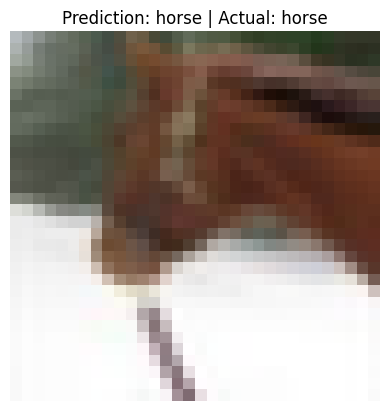

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load CIFAR-10
(ds_train, ds_test), info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

NUM_CLASSES = info.features['label'].num_classes
DATASET_NUM_TRAIN_EXAMPLES = info.splits['train'].num_examples

# Parameters
RESIZE_TO = 160
CROP_TO = 128
BATCH_SIZE = 32
SCHEDULE_LENGTH = 5000
STEPS_PER_EPOCH = 100
SCHEDULE_BOUNDARIES = [
    int(0.3 * SCHEDULE_LENGTH),
    int(0.6 * SCHEDULE_LENGTH),
    int(0.9 * SCHEDULE_LENGTH)
]

# Learning rate (scaled to batch size)
lr = 0.003 * BATCH_SIZE / 512

# Data Augmentation
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, [CROP_TO, CROP_TO])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Pipelines
pipeline_train = (ds_train
    .shuffle(10000)
    .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1)
    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))

pipeline_test = (ds_test
    .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE))

# Load BiT model
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"  # image classification on Imagenet
bit_module = hub.KerasLayer(bit_model_url, trainable=True)

# Custom model
class MyBiTModel(tf.keras.Model):
    def __init__(self, num_classes, module):
        super().__init__()
        self.bit_model = module
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')

    def call(self, inputs, training=False):
        x = self.bit_model(inputs)
        x = self.dropout(x, training=training)
        return self.head(x)

model = MyBiTModel(NUM_CLASSES, bit_module)

# Optimizer & loss
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[lr, lr * 0.1, lr * 0.01, lr * 0.001]
)

# optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=lr_schedule) # TF 2.10

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train
model.fit(
    pipeline_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    validation_data=pipeline_test
)

# Prediction sample
label_names = info.features['label'].names
for image, label in ds_test.take(1):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize(input_image, [CROP_TO, CROP_TO])
    input_image = tf.cast(input_image, tf.float32) / 255.0

    logits = model(input_image)
    prediction = tf.argmax(logits, axis=-1).numpy()[0]

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {label_names[prediction]} | Actual: {label_names[label.numpy()]}")
    plt.show()
